In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import os #for dic and file operation
import numpy as np #for numerical operation and handling image array operation
import random #for genrating random value of data augmentation
from PIL import Image,ImageEnhance# for imge processing and Enhancement
from tensorflow.keras.models import Sequential #for building the model
from tensorflow.keras.layers import Dense,Input,Flatten,Dropout # for model layer
from tensorflow.keras.preprocessing.image import load_img # for loading images
from tensorflow.keras.optimizers import Adam # for optimizer
from tensorflow.keras.applications import VGG16 # for tranfer learning
from sklearn.utils import shuffle # for shuffling the all images data

In [ ]:
## directory for training and testing
train_dir="/kaggle/input/brain-tumor-mri-dataset/Training"
test_dir="/kaggle/input/brain-tumor-mri-dataset/Testing"

# load and shuffle the train data
train_paths=[]
train_labels=[]
for label in os.listdir(train_dir):
    for image in os.listdir(os.path.join(train_dir,label)):
        train_paths.append(os.path.join(train_dir,label,image))
        train_labels.append(label)
train_paths,train_labels = shuffle(train_paths,train_labels)

In [ ]:
# load and shuffle the test data
test_paths=[]
test_labels=[]
for label in os.listdir(test_dir):
    for image in os.listdir(os.path.join(test_dir,label)):
        test_paths.append(os.path.join(test_dir,label,image))
        test_labels.append(label)
test_paths,test_labels = shuffle(test_paths,test_labels)

In [ ]:
import random
from PIL import Image
import matplotlib.pyplot as plt

#select random indcies for 10 images
random_indices = random.sample(range(len(train_paths)),10)

In [ ]:
#create a fig to display images in 2 rows
fig,axes=plt.subplots(2,5,figsize=(15,6))
axes=axes.ravel()


# Loop through the random indices and display images
for i, idx in enumerate(random_indices):
    img_path = train_paths[idx]
    img = Image.open(img_path)   #  Corrected line
    img = img.resize((128, 128))
    
    # display images
    axes[i].imshow(img)
    axes[i].axis("off")
    axes[i].set_title(f"Label:{train_labels[idx]}",fontsize=20)
    
    
plt.tight_layout()
plt.show()

In [ ]:
# Image Augmentation function
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))  # Random brightness
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))  # Random contrast
    image = np.array(image) / 255.0  # Normalize pixel values to [0, 1]
    return image

# Load images and apply augmentation
def open_images(paths):
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

# Encoding labels (convert label names to integers)
def encode_label(labels):
    unique_labels = os.listdir(train_dir)  # Ensure unique labels are determined
    encoded = [unique_labels.index(label) for label in labels]
    return np.array(encoded)

# Data generator for batching
def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i + batch_size]
            batch_images = open_images(batch_paths)  # Open and augment images
            batch_labels = labels[i:i + batch_size]
            batch_labels = encode_label(batch_labels)  # Encode labels
            yield batch_images, batch_labels  # Yield the batch

In [ ]:
# image Architecture RGB(121,128,3)

IMAGE_SIZE=128
base_model=VGG16(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3),include_top=False,weights='imagenet')


#freeze all layer OF THE vgg16 base model
for layers in base_model.layers:
    layers.trainable=False



# set only the last few layers
base_model.layers[-2].trainable=True
base_model.layers[-3].trainable=True
base_model.layers[-4].trainable=True

In [ ]:
# Build model
model=Sequential()
# model.add(input(shape=(IMAGE_SIZE,IMAGE_SIZE,3)))
model.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))#INPUT LAYER
model.add(base_model)
model.add(Flatten())#Flatten layer
model.add(Dropout(0.3))

model.add(Dense(128,activation="relu"))#Dense layer
model.add(Dropout(0.2)) #Droupout layer

model.add(Dense(len(os.listdir(train_dir)),activation='softmax')) #Output layer

In [ ]:
#Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])
#Paramters
batch_size=20
steps=int(len(train_paths)/batch_size)
epochs=5

In [ ]:
# Parameters
batch_size = 20
steps = int(len(train_paths) / batch_size)  # Steps per epoch
epochs = 5

In [ ]:
# Train the model
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),epochs=epochs, steps_per_epoch=steps)

In [ ]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'],'.g-',linewidth=2)
plt.plot(history.history['loss'],'.r-',linewidth=2)
plt.title('Model training history')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'],loc='upper left',bbox_to_anchor=(1,1))
plt.show

# Model classification Report on Test Data

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize

In [ ]:
test_images=open_images(test_paths)
test_labels_encoded =encode_label(test_labels)
test_predictions=model.predict(test_images)

In [ ]:
print('classification report:')
print(classification_report(test_labels_encoded,np.argmax(test_predictions,axis=1)))

# Model Confusion Matrix

In [ ]:
conf_matrix=confusion_matrix(test_labels_encoded,np.argmax(test_predictions,axis=1))
print("confusion matrix:")
print(conf_matrix)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix,annot=True,fmt='d',cmap='Blues',xticklabels=os.listdir(train_dir),yticklabels=os.listdir(train_dir))
plt.xlabel('predicted')
plt.ylabel('True')
plt.title("Confusion Matrix")

# Roc curve

In [ ]:
# 4. ROC Curve and AUC
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

y_true = label_binarize(test_labels_encoded, classes=range(len(np.unique(test_labels_encoded))))
plt.figure(figsize=(7,6))
for i in range(y_true.shape[1]):
    fpr, tpr, _ = roc_curve(y_true[:, i], test_predictions[:, i])
    plt.plot(fpr, tpr, label=f'Class {i} (AUC={auc(fpr,tpr):.2f})')
plt.plot([0,1],[0,1],'k--'); plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC Curve'); plt.legend(); plt.show()

# Save and Load Model

In [ ]:
model.save('model.h5')

In [ ]:
# Load model
from tensorflow.keras.models import load_model
model = load_model('model.h5')

# MRI Tumor Detection System

In [ ]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Class labels
class_labels = ['pituitary', 'glioma', 'notumor', 'meningioma']

def detect_and_display(img_path, model, image_size=128):
    """
    Function to detect tumor and display results.
    If no tumor is detected, it displays "No Tumor".
    Otherwise, it shows the predicted tumor class and confidence.
    """
    try:
        # Load and preprocess the image
        img = load_img(img_path, target_size=(image_size, image_size))
        img_array = img_to_array(img) / 255.0  # Normalize pixel values
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Make a prediction
        predictions = model.predict(img_array)
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        confidence_score = np.max(predictions, axis=1)[0]

        # Determine the class
        if class_labels[predicted_class_index] == 'notumor':
            result = "No Tumor"
        else:
            result = f"Tumor: {class_labels[predicted_class_index]}"

        # Display the image with the prediction
        plt.imshow(load_img(img_path))
        plt.axis('off')
        plt.title(f"{result} (Confidence: {confidence_score * 100:.2f}%)")
        plt.show()

    except Exception as e:
        print("Error processing the image:", str(e))

In [50]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Class labels
class_labels = ['pituitary', 'glioma', 'notumor', 'meningioma']

def detect_and_display(img_path, model, image_size=128):
    """
    Function to detect tumor and display results.
    If no tumor is detected, it displays "No Tumor".
    Otherwise, it shows the predicted tumor class and confidence.
    """
    try:
        # Load and preprocess the image
        img = load_img(img_path, target_size=(image_size, image_size))
        img_array = img_to_array(img) / 255.0  # Normalize pixel values
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Make a prediction
        predictions = model.predict(img_array)
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        confidence_score = np.max(predictions, axis=1)[0]

        # Determine the class
        if class_labels[predicted_class_index] == 'notumor':
            result = "No Tumor"
        else:
            result = f"Tumor: {class_labels[predicted_class_index]}"

        # Display the image with the prediction
        plt.imshow(load_img(img_path))
        plt.axis('off')
        plt.title(f"{result} (Confidence: {confidence_score * 100:.2f}%)")
        plt.show()

    except Exception as e:
        print("Error processing the image:", str(e))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


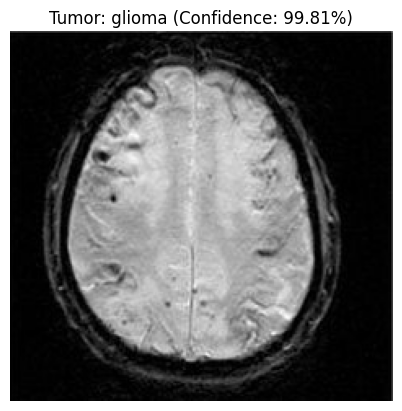

In [51]:
# Example 1

image_path="/kaggle/input/brain-tumor-mri-dataset/Testing/notumor/Te-noTr_0008.jpg"
detect_and_display(image_path,model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


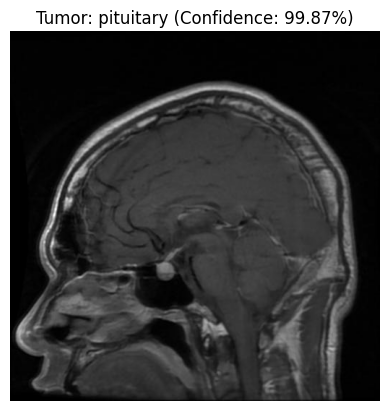

In [52]:
# Example 2

image_path="/kaggle/input/brain-tumor-mri-dataset/Testing/pituitary/Te-piTr_0006.jpg"
detect_and_display(image_path,model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


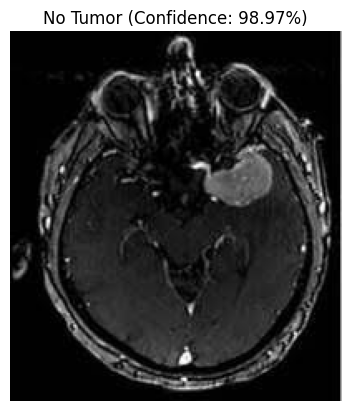

In [53]:
# Example 3

image_path="/kaggle/input/brain-tumor-mri-dataset/Testing/meningioma/Te-me_0011.jpg"
detect_and_display(image_path,model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


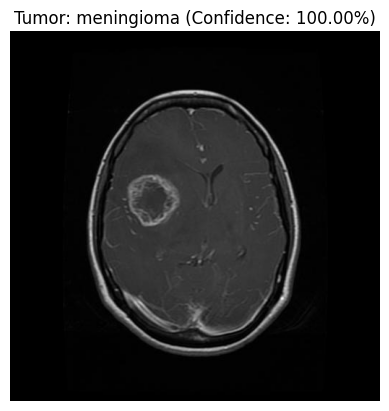

In [54]:
# Example 4

image_path="/kaggle/input/brain-tumor-mri-dataset/Testing/glioma/Te-gl_0014.jpg"
detect_and_display(image_path,model)